In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import bayesnewton
import matplotlib.cm as cm
import time
import objax
from tqdm.notebook import trange, tqdm

rng = np.random.RandomState(123)

## Data

### Temperature

In [2]:
%%time

ds = xr.tutorial.open_dataset("air_temperature").load()

CPU times: user 189 ms, sys: 34.1 ms, total: 223 ms
Wall time: 324 ms


In [3]:
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

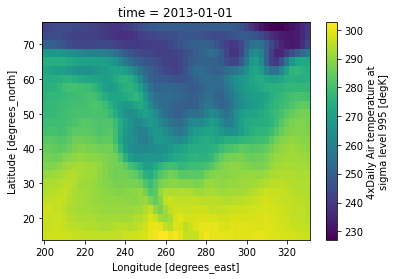

In [4]:
ds.air.isel(time=0).plot()

In [20]:
subset_ds = ds.isel(time=slice(0, 50), lat=slice(-50, 10), lon=slice(-50, 20))
subset_ds

<xarray.Dataset>
Dimensions:  (lat: 10, time: 50, lon: 17)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 62.5 60.0 57.5 55.0 52.5
  * lon      (lon) float32 207.5 210.0 212.5 215.0 ... 240.0 242.5 245.0 247.5
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-01-13T06:00:00
Data variables:
    air      (time, lat, lon) float32 244.0 244.1 243.9 ... 257.2 259.5 261.4
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

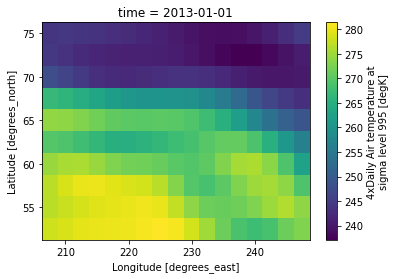

In [22]:
subset_ds.air.isel(time=0).plot()

## Dataset Dimensions

* Latitude 
* Longitude
* Total Spatial Dims
* Time
* Total Dims
* Total Variables

In [23]:
# number of time
nt = subset_ds.time.shape[0]

# spatial dimensions
n_lat = subset_ds.lat.shape[0]
n_lon = subset_ds.lon.shape[0]
n_latlon = n_lat * n_lon
n_coords = 2

# variable dimensions
n_vars = 1

In [24]:
n_dims = n_vars * n_latlon * nt

print(f"Total Dims: {n_dims:,}")

Total Dims: 8,500


In [25]:
# N = Y_obs.shape[0] * Y_obs.shape[1] * Y_obs.shape[2]

# print(f"Num data points: {N:,}")

In [26]:
data = subset_ds.to_dataframe().reset_index()
data.head()

,lat,time,lon,air
0,75.0,2013-01-01,207.5,244.000000
1,75.0,2013-01-01,210.0,244.099991
2,75.0,2013-01-01,212.5,243.889999
3,75.0,2013-01-01,215.0,243.599991
4,75.0,2013-01-01,217.5,243.099991


### Train Split

In [27]:
# create random test indices
test_ind = rng.permutation(n_dims)[:n_dims//10]


# data_train = 

In [28]:
# nd = subset_ds.shape[0]

In [29]:
nt = np.shape(np.unique(subset_ds.coords["time"].values))[0]
nt

50

In [30]:
# binsize (delta t)
binsize = 1000 / nt

In [31]:
# subset_ds.air.shape, time_stamp.shape, lat.shape, lon.shape

In [32]:
Y = data["air"].values
time_stamp = data["time"].astype(np.int64) // 10 ** 9
lat = data["lat"].values
lon = data["lon"].values
X = np.stack([time_stamp, lat, lon], axis=1)
Y.shape, X.shape

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_51094/1360219582.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  time_stamp = data["time"].astype(np.int64) // 10 ** 9


((8500,), (8500, 3))

In [19]:
X[:, 2]

array([200. , 202.5, 205. , ..., 325. , 327.5, 330. ])

In [33]:
%%time

t, R, Y_obs = bayesnewton.utils.create_spatiotemporal_grid(X, Y)

t.shape, R.shape, Y_obs.shape

CPU times: user 405 ms, sys: 59.1 ms, total: 464 ms
Wall time: 449 ms


((50, 1), (50, 170, 2), (50, 170, 1))

((50, 1), (50, 1325, 2), (50, 1325, 1))

In [200]:
X = np.concatenate([t[:, None], R[:, None]], axis=1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [165]:
assert t.shape == (nt, 1)
assert R.shape == (nt, n_d, n_coords)
assert Y_obs.shape == (nt, n_d, n_vars)

In [166]:
Nt = t.shape[0]
print(f"Num Time Steps: {Nt:,}")

Num Time Steps: 50


### Sparse Points

In [52]:
z1 = np.linspace(np.min(X[:,1]), np.max(X[:, 1]), num=7)
z2 = np.linspace(np.min(X[:,2]), np.max(X[:, 2]), num=7)

zA, zB = np.meshgrid(z1, z2)

z = np.hstack((zA.reshape(-1, 1), zB.reshape(-1, 1)))

In [53]:
z.shape, R[0, ...].shape

((49, 2), (170, 2))

In [128]:
var_f = 1.  # GP variance
len_f = 1.  # lengthscale
len_time = 1
len_space = 1
sparse = True
opt_z = True

In [129]:
# kernel
kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

In [130]:
kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='Full')

In [131]:
%%time

# likelihood
lik = bayesnewton.likelihoods.Gaussian(variance=1)

# model
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=Y_obs)

CPU times: user 673 ms, sys: 309 ms, total: 983 ms
Wall time: 254 ms


In [132]:
lr_adam = 0.1
lr_newton = 0.5
iters = 1_000
opt_hypers = objax.optimizer.Adam(model.vars())

In [133]:
energy = objax.GradValues(model.energy, model.vars())

In [134]:
@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op():
    model.inference(lr=lr_newton)  # perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(lr_adam, dE)
    # test_nlpd_ = model.negative_log_predictive_density(X=t_test, R=r_test, Y=Y_test)
    return E


train_op = objax.Jit(train_op)

In [135]:
t0 = time.time()

losses = []

with trange(1, iters + 1) as pbar:
    for i in pbar:
        loss = train_op()

        losses.append(np.array(loss[0]))
        
        pbar.set_description(f"iter {i:d}, energy: {loss[0]:1.4f}")
        
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

  0%|          | 0/1000 [00:00<?, ?it/s]

optimisation time: 628.86 secs


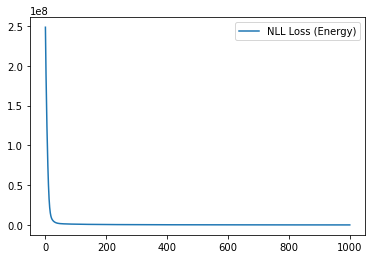

In [136]:
fig, ax = plt.subplots()

ax.plot(losses, label="NLL Loss (Energy)")
plt.legend()
plt.show()

In [137]:
N_test = 20  # 50

# r1 = np.unique(X[:, 1])
# r2 = np.unique(X[:, 2])
X1range = max(X[:, 1]) - min(X[:, 1])
X2range = max(X[:, 2]) - min(X[:, 2])
r1 = np.linspace(min(X[:, 1]) - 0.1 * X1range, max(X[:, 1]) + 0.1 * X1range, num=N_test)
r2 = np.linspace(min(X[:, 2]) - 0.05 * X2range, max(X[:, 2]) + 0.05 * X2range, num=N_test)
rA, rB = np.meshgrid(r1, r2)
r = np.hstack((rA.reshape(-1, 1), rB.reshape(-1, 1)))  # Flattening grid for use in kernel functions
Rplot = np.tile(r, [t.shape[0], 1, 1])


In [138]:
Rplot.shape, t.shape

((50, 400, 2), (50, 1))

In [139]:
%%time

posterior_mean, posterior_var = model.predict(X=t, R=Rplot)

CPU times: user 4.51 s, sys: 1.74 s, total: 6.24 s
Wall time: 1.62 s


In [140]:
mu = bayesnewton.utils.transpose(posterior_mean.reshape(-1, N_test, N_test))

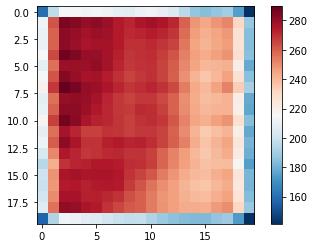

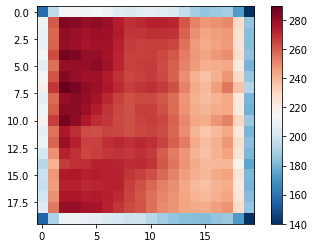

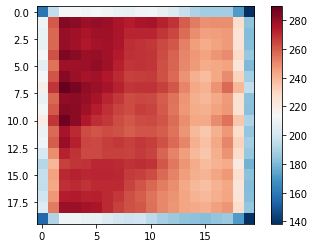

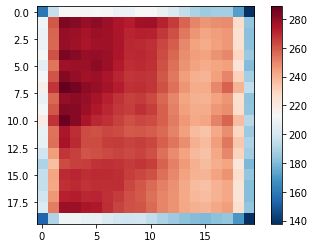

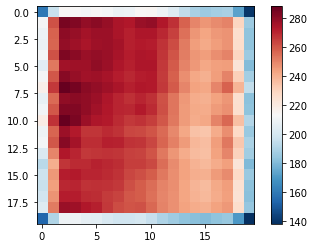

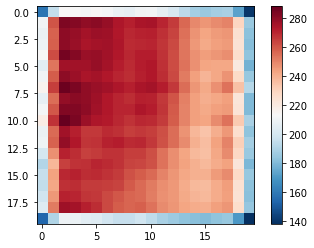

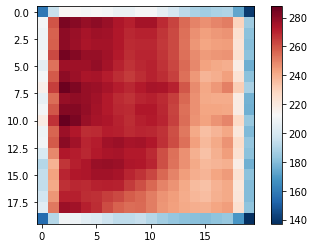

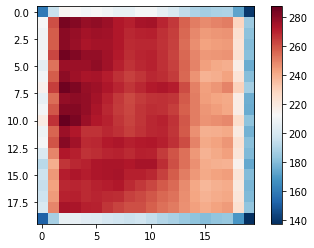

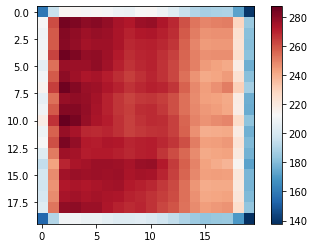

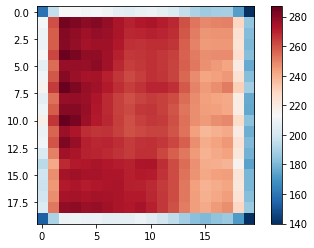

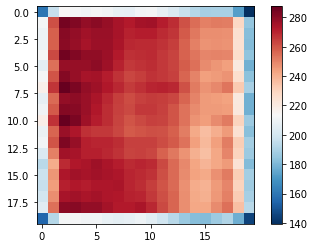

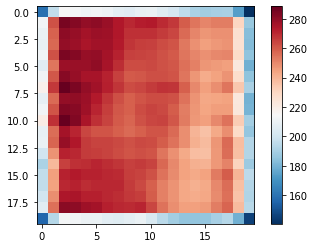

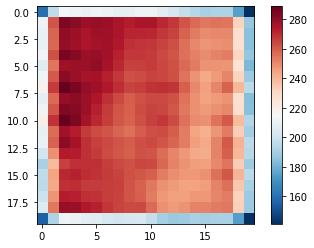

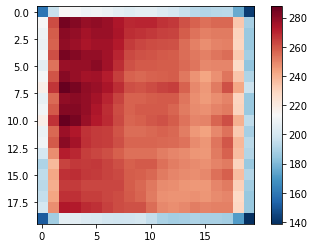

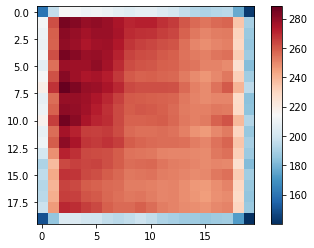

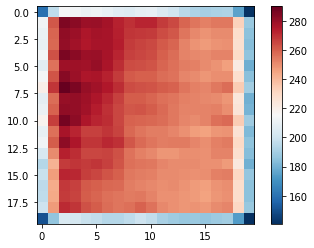

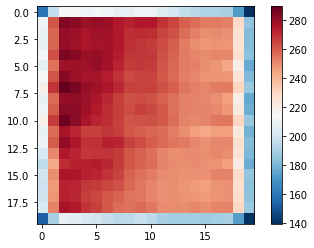

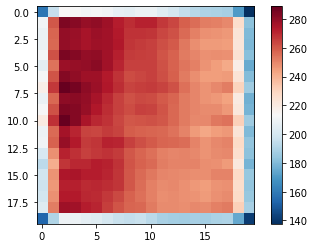

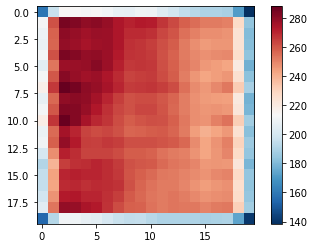

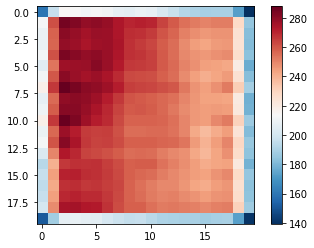

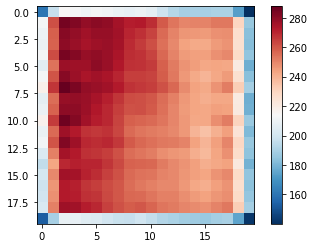

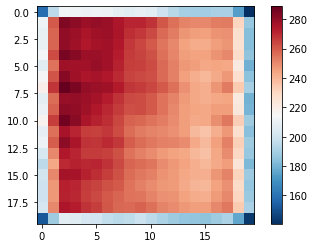

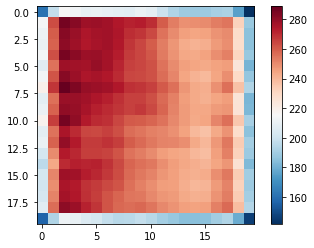

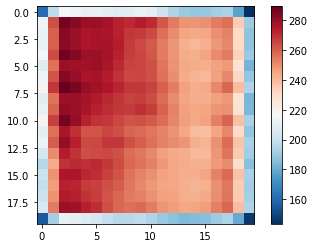

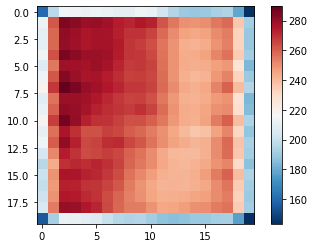

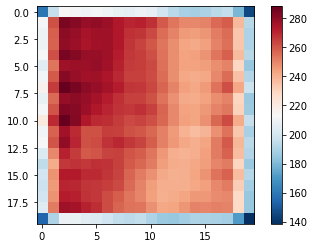

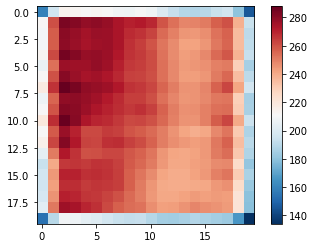

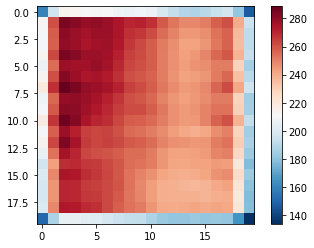

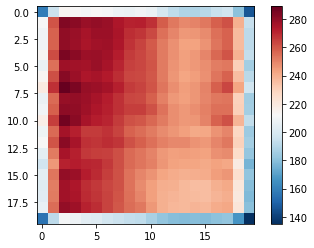

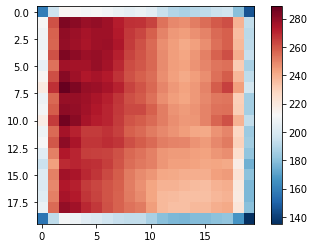

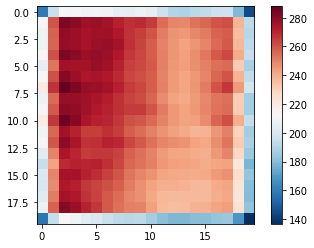

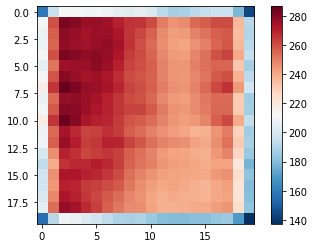

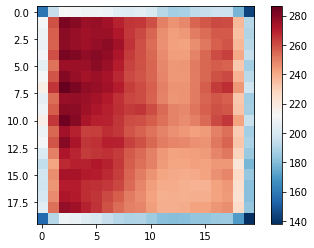

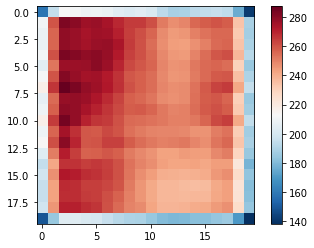

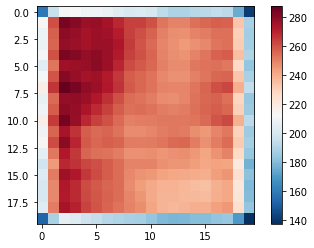

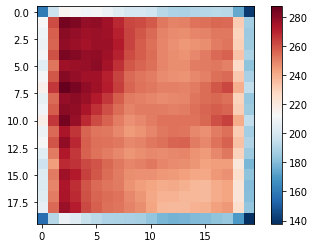

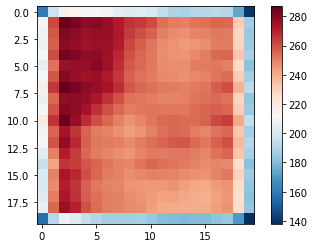

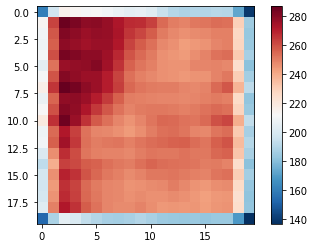

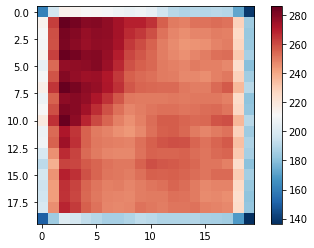

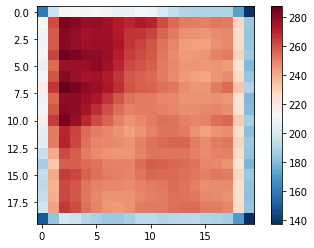

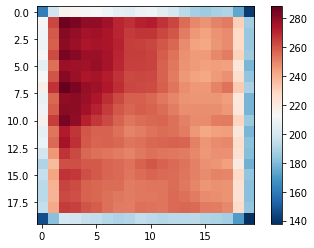

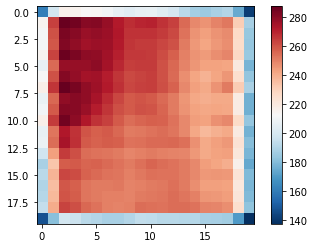

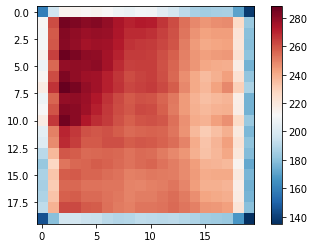

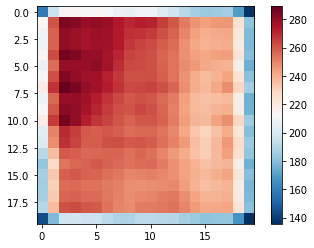

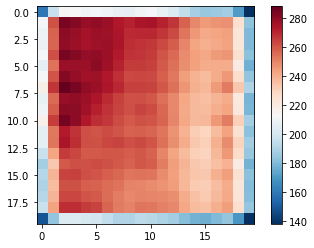

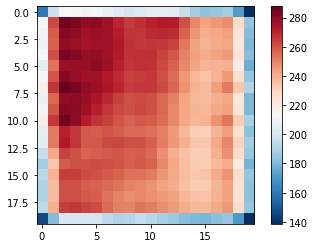

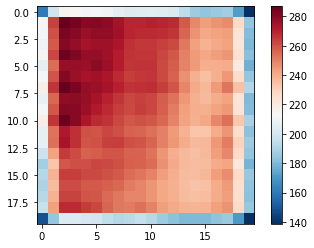

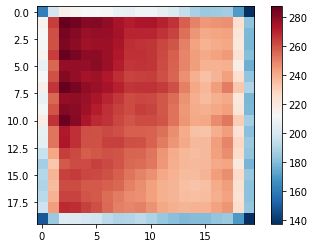

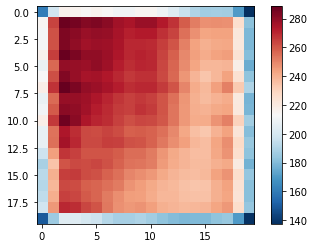

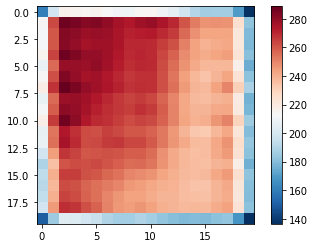

In [145]:
for i in range(len(mu)):

    fig, ax = plt.subplots()

    im = ax.imshow(mu[i].T, cmap="RdBu_r")
    plt.colorbar(im)
    plt.show()

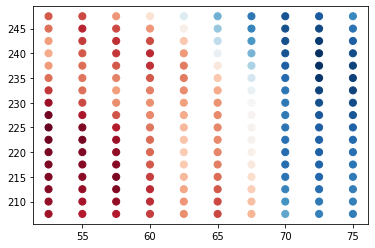

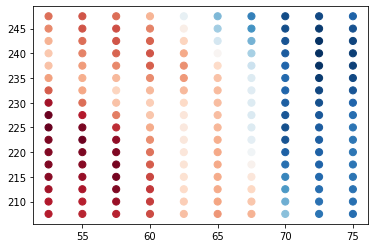

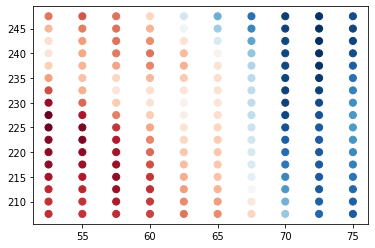

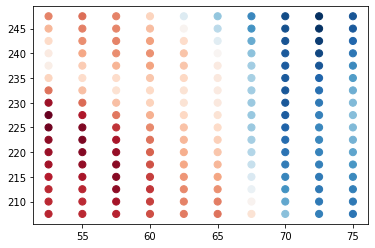

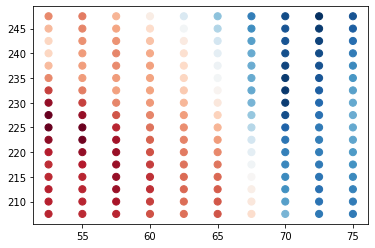

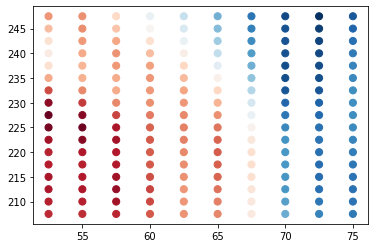

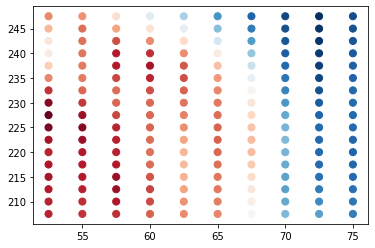

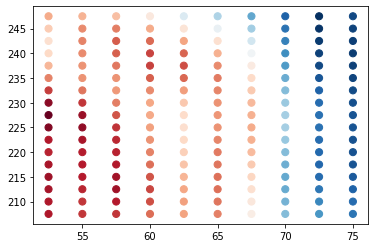

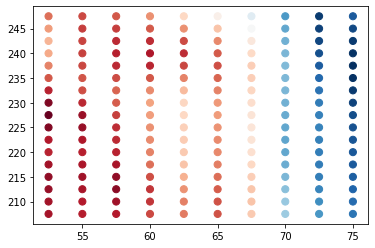

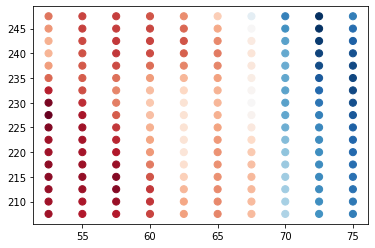

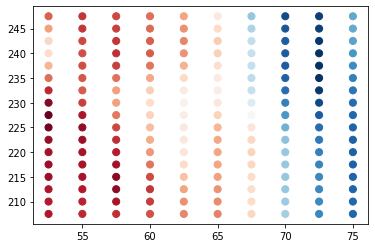

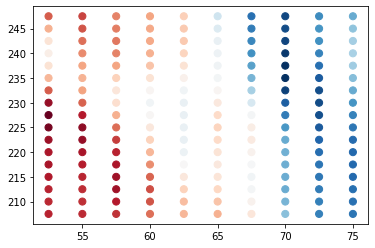

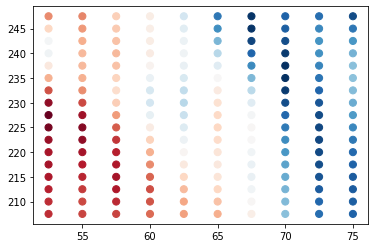

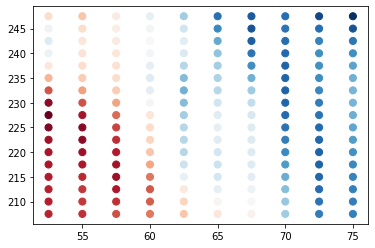

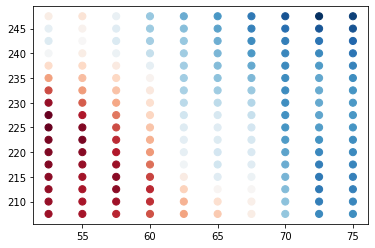

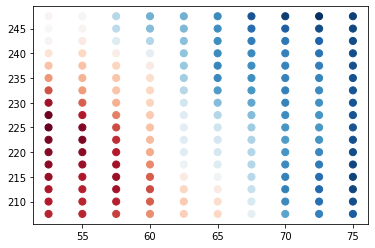

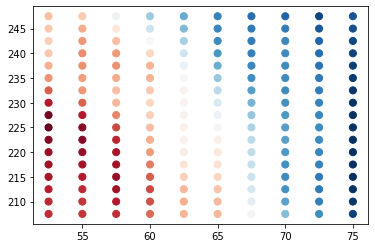

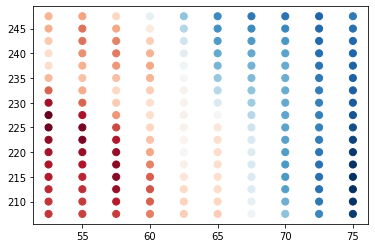

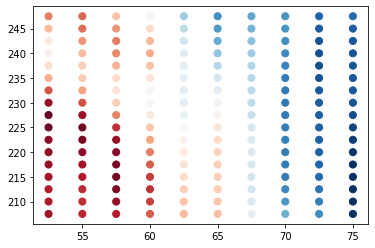

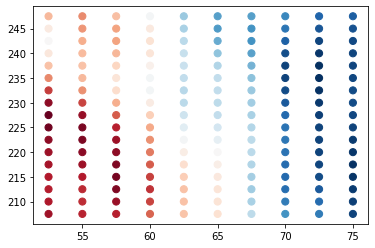

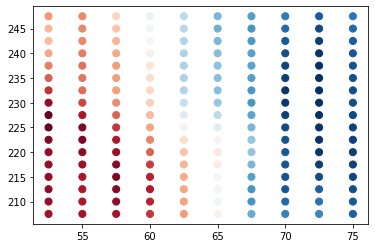

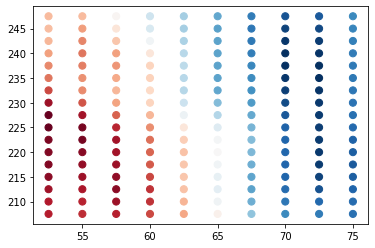

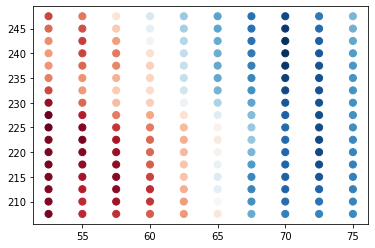

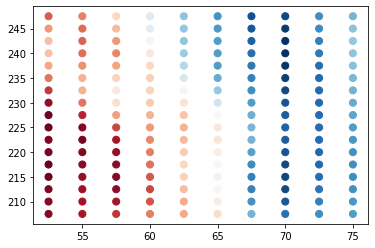

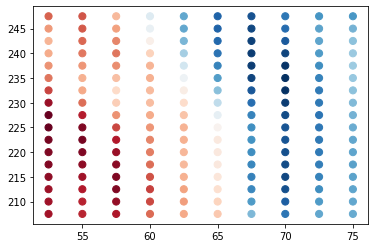

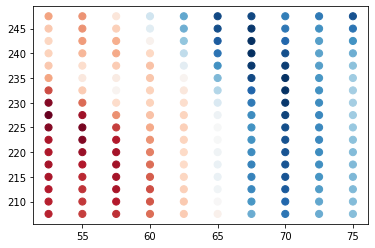

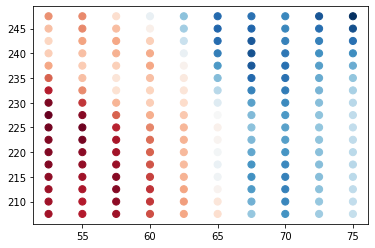

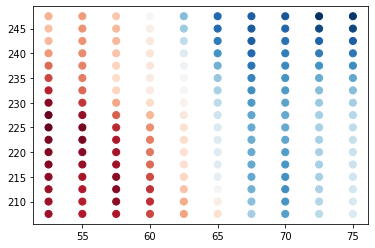

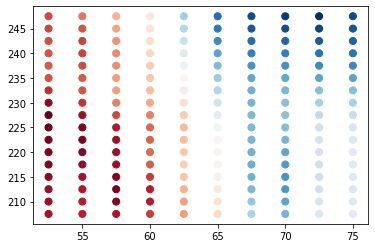

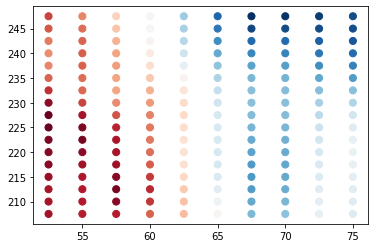

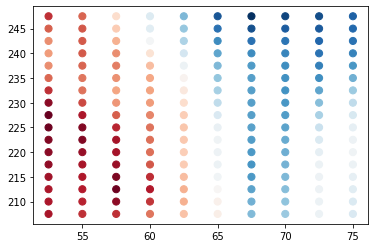

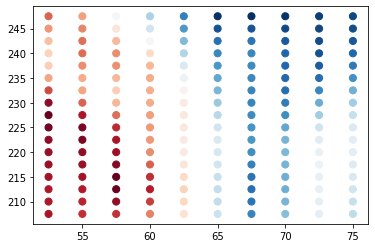

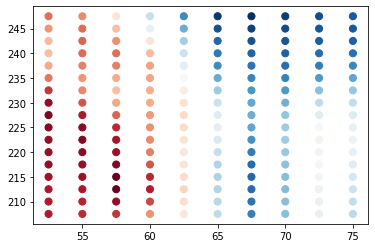

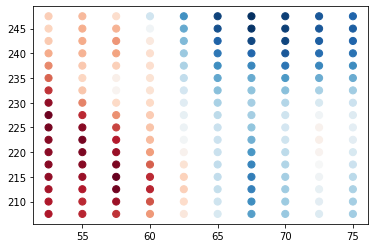

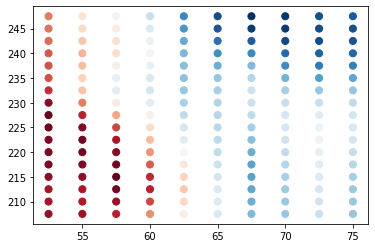

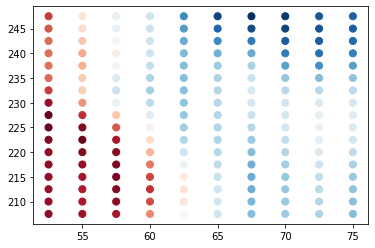

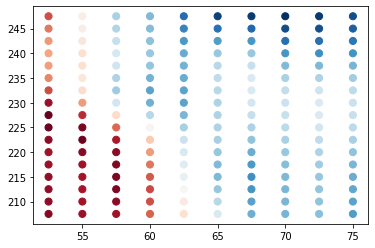

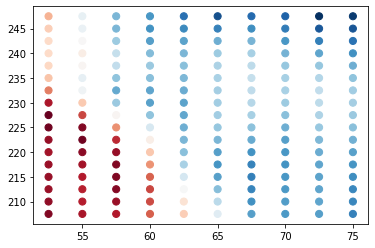

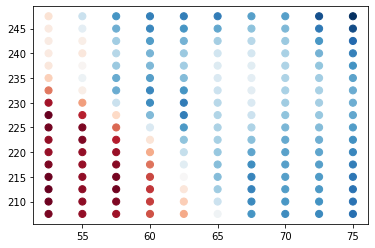

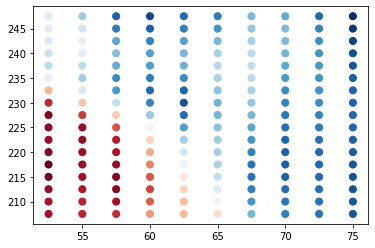

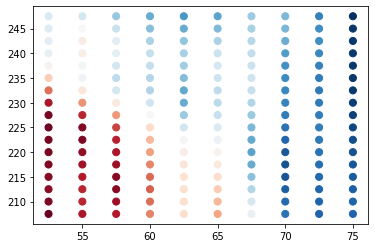

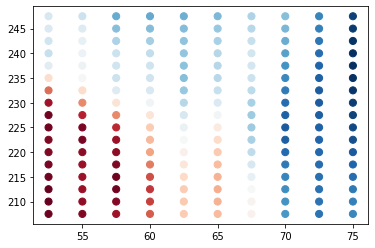

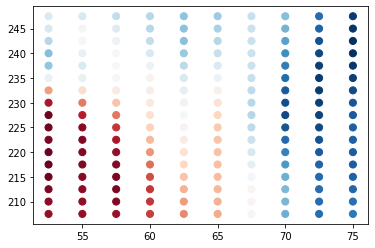

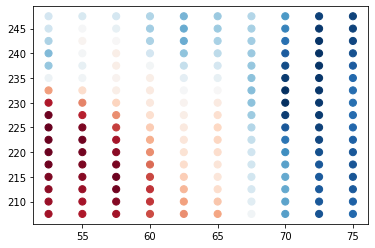

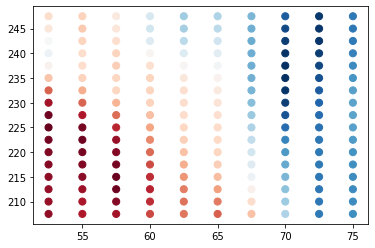

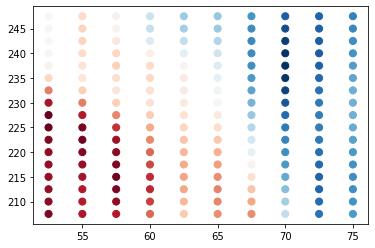

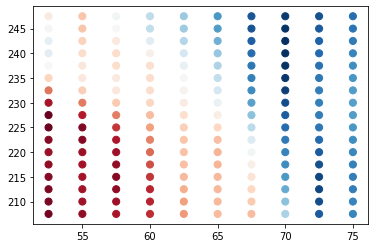

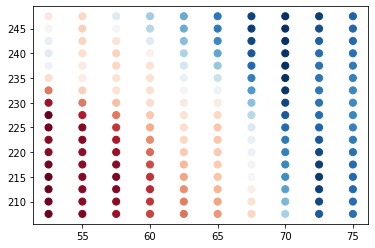

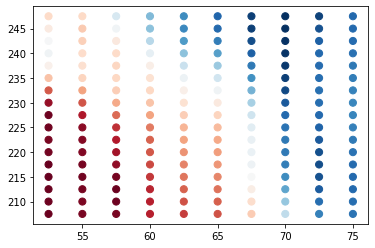

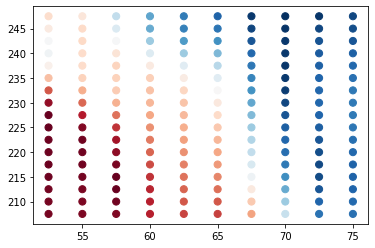

In [144]:
for i in range(len(mu)):

    fig, ax = plt.subplots()

    ax.scatter(R[i, :, 0], R[i, :, 1], c=np.squeeze(Y_obs[i]), s=50, cmap="RdBu_r")
    plt.show()

### Flatten

In [168]:
t_flat = np.array(t).flatten()
R_flat = np.array(R).flatten()
Y_flat = np.array(Y_obs).flatten()

In [169]:
t_flat.shape, nt, nt/10

((50,), 50, 5.0)

In [170]:
test_ind.shape, Y_obs.shape

((5,), (50, 1325, 1))

In [164]:
Y_flat.shape, test_ind.shape

((66250,), (5,))

In [171]:
# create random test indices
test_ind = rng.permutation(N)[:N//10]

# subset data
t_test = t_flat[test_ind]
r_test = R_flat[test_ind]
Y_test = Y_flat[test_ind]

Y_flat[test_ind] = np.nan

Y = Y_flat.reshape(nt, n_latlon)

IndexError: index 19787 is out of bounds for axis 0 with size 50

In [161]:
Y_img = Y.reshape((nt, n_lat, n_lon))

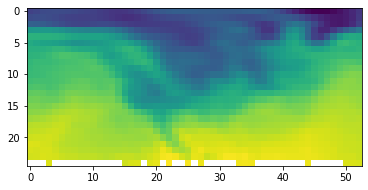

In [162]:
fig, ax = plt.subplots()

ax.imshow(Y_img[0, ::-1, :])

plt.show()

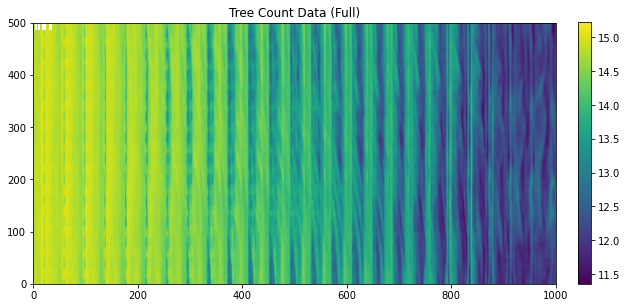

In [139]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(Y / binsize, extent=[0, 1_000, 0, 500], cmap=cm.viridis)
ax.set(title="Temperature Data (Full)")
plt.colorbar(im, fraction=0.0235, pad=0.04)
plt.show()

In [44]:
T.shape, R1.shape, R2.shape

((2920, 1), (2920, 1325, 2), (2920, 1325, 1))

In [28]:
Y = ds.air
time = ds.coords["time"].values
time_steps = np.arange(time.shape[0])
lat = ds.coords["lat"].values
lon = ds.coords["lon"].values

In [33]:
time_steps.shape, lat.shape, lon.shape

((2920,), (25,), (53,))

In [31]:
X = np.vstack([time_steps, lat, lon])

print(X.shape, Y.shape)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2920 and the array at index 1 has size 25

#### Viz - Basemap

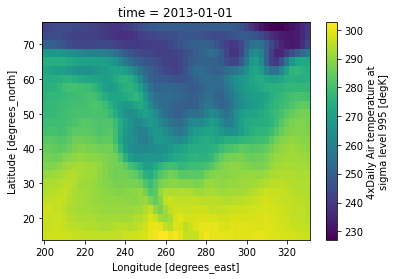

In [12]:
ds.air[0].plot()

#### Viz - Time Series


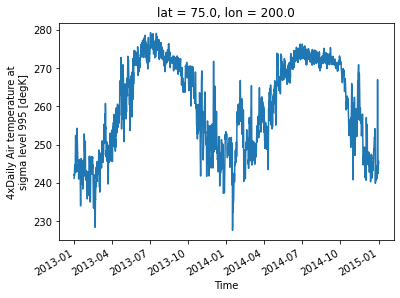

In [13]:
ds.air[:, 0, 0].plot()

### ROMS Model

In [14]:
%%time

ds = xr.tutorial.open_dataset("ROMS_example").load()


CPU times: user 357 ms, sys: 108 ms, total: 465 ms
Wall time: 1.94 s


In [15]:
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 2, s_rho: 30, eta_rho: 191, xi_rho: 371)
Coordinates:
    Cs_r        (s_rho) float64 -0.933 -0.8092 -0.6988 ... -0.0005206 -5.758e-05
    lon_rho     (eta_rho, xi_rho) float64 -93.6 -93.58 -93.57 ... -88.88 -88.87
    hc          float64 20.0
    h           (eta_rho, xi_rho) float64 612.1 610.9 609.7 ... 5.0 5.0 5.0
    lat_rho     (eta_rho, xi_rho) float64 27.45 27.45 27.45 ... 30.85 30.86
    Vtransform  int32 2
  * ocean_time  (ocean_time) datetime64[ns] 2001-08-01 2001-08-08
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 34.95 34.96 ... nan
    zeta        (ocean_time, eta_rho, xi_rho) float32 -0.1565 -0.1553 ... nan
Attributes: (12/34)
    file:              ../output_20yr_obc/2001/ocean_his_0015.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             TXLA ROMS hindcast run with dyes and oxygen
    rst_file:          ../output_20yr_obc/2001/ocean_rst.nc
    ...                ...
    compiler_flags:    -heap-arrays -fp-model fast -mt_mpi -ip -O3 -msse2 -free
    tiling:            010x012
    history:           Tue Jul 24 11:04:43 2018: /opt/nco/ncks -D 4 -t 8 /cop...
    ana_file:          /home/d.kobashi/TXLA_ROMS_reana/Functionals/ana_btflux...
    CPP_options:       TXLA2, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_NUDGCOE...
    NCO:               netCDF Operators version 4.7.6-alpha04 (Homepage = htt...

### Viz - Gridded

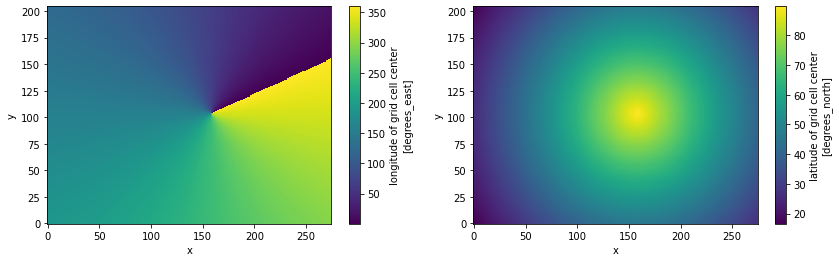

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))
ds.xc.plot(ax=ax1)
ds.yc.plot(ax=ax2)

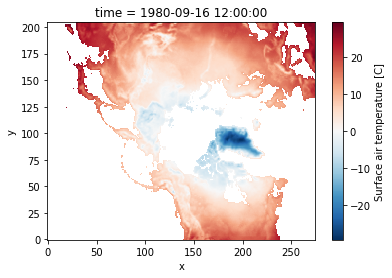

In [6]:
ds.Tair[0].plot()